1- Import XRay Images


In [2]:
import os 
import cv2
import numpy as np 
# traitement dataframe
import pandas as pdœ
# permet de faire des graphiques
import matplotlib.pyplot as plt
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import cross_validate


# Analyse du dataset

Le dataset est composé d'images de radiographies thoraciques. Le dataset est déjà divisé en train, val et test. Les données sont classées en NORMAL et PNEUMONIA. Les images de radiographies thoraciques sont en niveaux de gris.

Le problème est donc un problème de classification binaire. L'objectif est de prédire si une personne est atteinte de pneumonie ou non.

In [10]:
images_path = "./chest_Xray"

In [26]:
images_files = os.listdir(images_path)
subfolders = ["train","val","test"]
categories = ["NORMAL","PNEUMONIA"]

for subfolder in subfolders:
    for category in categories:
        # pour avoir tous les chemins des 6 dossiers
        folder_path = os.path.join(images_path,subfolder,category)
        # liste de toutes les images
        images_files = os.listdir(folder_path)
        imgs = []
        for file_name in images_files[:5]:
            image_path = os.path.join(folder_path,file_name)
            img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
            imgs.append(img.shape)
        print("tailles des premières images du dossier {} : {}".format(folder_path, imgs) )

tailles des premières images du dossier ./chest_Xray/train/NORMAL : [(1279, 1670), (1129, 1574), (1391, 1646), (1670, 1820), (1102, 1338)]
tailles des premières images du dossier ./chest_Xray/train/PNEUMONIA : [(560, 936), (1447, 1841), (928, 1352), (632, 1016), (688, 952)]
tailles des premières images du dossier ./chest_Xray/val/NORMAL : [(1416, 1736), (1225, 1632), (1040, 1272), (928, 1288), (1302, 1564)]
tailles des premières images du dossier ./chest_Xray/val/PNEUMONIA : [(592, 968), (712, 1072), (864, 1256), (664, 1152), (944, 1416)]
tailles des premières images du dossier ./chest_Xray/test/NORMAL : [(1357, 1890), (1504, 1741), (1326, 1862), (912, 1392), (1953, 2170)]
tailles des premières images du dossier ./chest_Xray/test/PNEUMONIA : [(640, 832), (560, 952), (936, 1216), (1144, 1592), (648, 1032)]


On constate que les radios sont différentes tailles. L'uniformisation des données est une étape importante du prétraitement des données. Il faudra donc les redimensionner pour les passer en entrée d'un modèle de machine learning.

In [27]:
smallest_img_size = None
smallest_img_path = None
largest_img_size = None
largest_img_path = None
for subfolder in subfolders:
    for category in categories:
        folder_path = os.path.join(images_path,subfolder,category)
        images_files = os.listdir(folder_path)
        for file_name in images_files:
            image_path = os.path.join(folder_path,file_name)
            img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
            imgs.append(img.shape)
            if img is not None:
                if largest_img_size is None or img.shape > largest_img_size:
                    largest_img_size = img.shape
                    largest_img_path = image_path
                if smallest_img_size is None or img.shape < smallest_img_size:
                    smallest_img_size = img.shape
                    smallest_img_path = image_path
                    
print("L'image la plus petite a une taille de {} et se trouve à {}".format(smallest_img_size, smallest_img_path))
print("L'image la plus grande a une taille de {} et se trouve à {}".format(largest_img_size, largest_img_path))

L'image la plus petite a une taille de (127, 384) et se trouve à ./chest_Xray/train/PNEUMONIA/person407_virus_811.jpeg
L'image la plus grande a une taille de (2713, 2517) et se trouve à ./chest_Xray/test/NORMAL/NORMAL2-IM-0030-0001.jpeg


2- Class XrayLoader

In [4]:
class XrayLoader:
    def __init__(self, data_folder, image_size):
        self.x_train = None
        self.y_train = None
        self.x_val = None
        self.y_val = None
        self.x_test = None
        self.y_test = None
        self.data_folder = data_folder
        self.image_size = image_size

    def load_data(self):
        subfolders = ["train","val","test"]
        categories = ["NORMAL","PNEUMONIA"]
        data = {}

        for subfolder in subfolders:
            data[subfolder] = {"x":[],"y":[]}
            for category in categories:
                # pour avoir tous les chemins des 6 dossiers
                folder_path = os.path.join(self.data_folder,subfolder,category)
                # liste de toutes les images
                images_files = os.listdir(folder_path)
                for file_name in images_files:
                    image_path = os.path.join(folder_path,file_name)
                    img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img,self.image_size)
                    data[subfolder]["x"].append(img)
                    data[subfolder]["y"].append(category)
                
        self.x_train = np.array(data["train"]["x"])
        self.y_train = data["train"]["y"]
        self.x_val = np.array(data["val"]["x"])
        self.y_val = data["val"]["y"]
        self.x_test = np.array(data["test"]["x"])
        self.y_test = data["test"]["y"]

    def display_image(self,dataset,index):
        if dataset == 'train':
            image = self.x_train[index]
            label = self.y_train[index]
            
        elif dataset == 'test':
            image = self.x_test[index]
            label = self.y_test[index]
        else:
            raise ValueError('Invalid dataset. Choose either "train" or "test".')

        plt.imshow(image,cmap="gray")
        plt.title(f'Image {index} - Catégorie: {label}')
        plt.axis('off')
        plt.show()
    
    def display_category_means(self):
        normal_mean = self.calculate_category_mean(self.x_train, self.y_train, "NORMAL")
        pneumonia_mean = self.calculate_category_mean(self.x_train, self.y_train, "PNEUMONIA")

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(normal_mean, cmap="gray")
        plt.title("Mean NORMAL Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(pneumonia_mean, cmap="gray")
        plt.title("Mean PNEUMONIA Image")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    @staticmethod
    def calculate_category_mean(images, labels, category):
        images = np.array(images)
        labels = np.array(labels)
        category_images = images[labels == category]
        mean_image = np.mean(category_images, axis=0)
        return mean_image
    
    def display_distribution(self):
        test = ( self.y_test.count("NORMAL"), self.y_test.count("PNEUMONIA") )
        train = ( self.y_train.count("NORMAL"), self.y_train.count("PNEUMONIA") )
        val = ( self.y_val.count("NORMAL"), self.y_val.count("PNEUMONIA") )
        
        # Tracer les graphiques de distribution
        fig, ax = plt.subplots(1, 3, figsize=(30, 10))
        ax[0].bar(["NORMAL", "PNEUMONIA"], train)
        ax[0].set_title("Train Distribution")
        ax[1].bar(["NORMAL", "PNEUMONIA"], val)
        ax[1].set_title("Validation Distribution")
        ax[2].bar(["NORMAL", "PNEUMONIA"], test)
        ax[2].set_title("Test Distribution")
        plt.show()
    


In [5]:
loader = XrayLoader(data_folder='./chest_Xray', image_size=(800, 800))
loader.load_data()
xtrain = loader.x_train
ytrain = loader.y_train
xtest = loader.x_test
ytest = loader.y_test
xval = loader.x_val
yval = loader.y_val

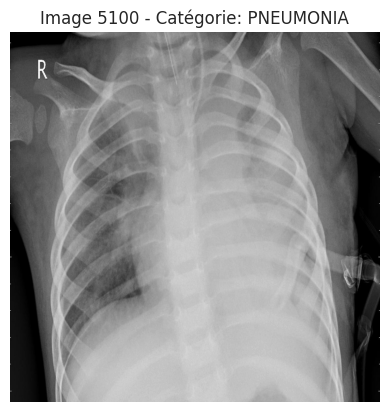

In [6]:
loader.display_image("train",5100)

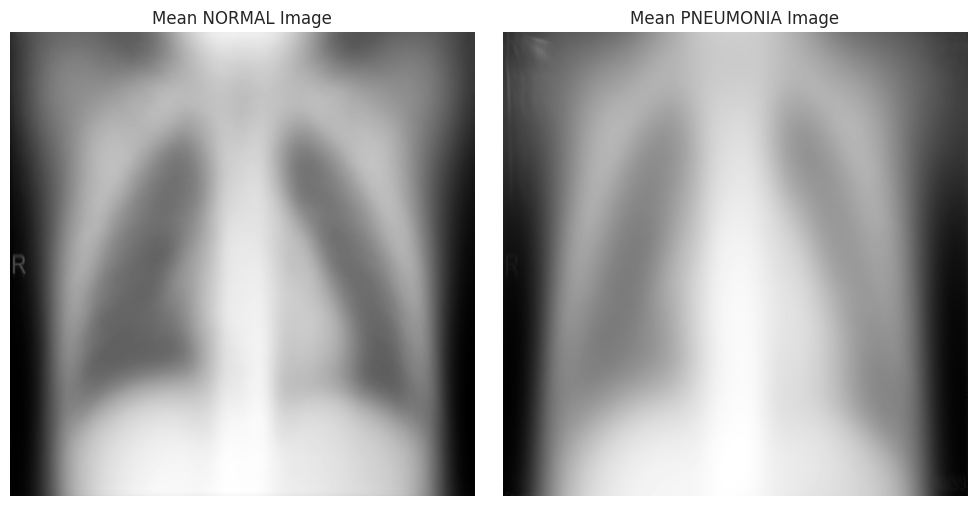

In [7]:
loader.display_category_means()

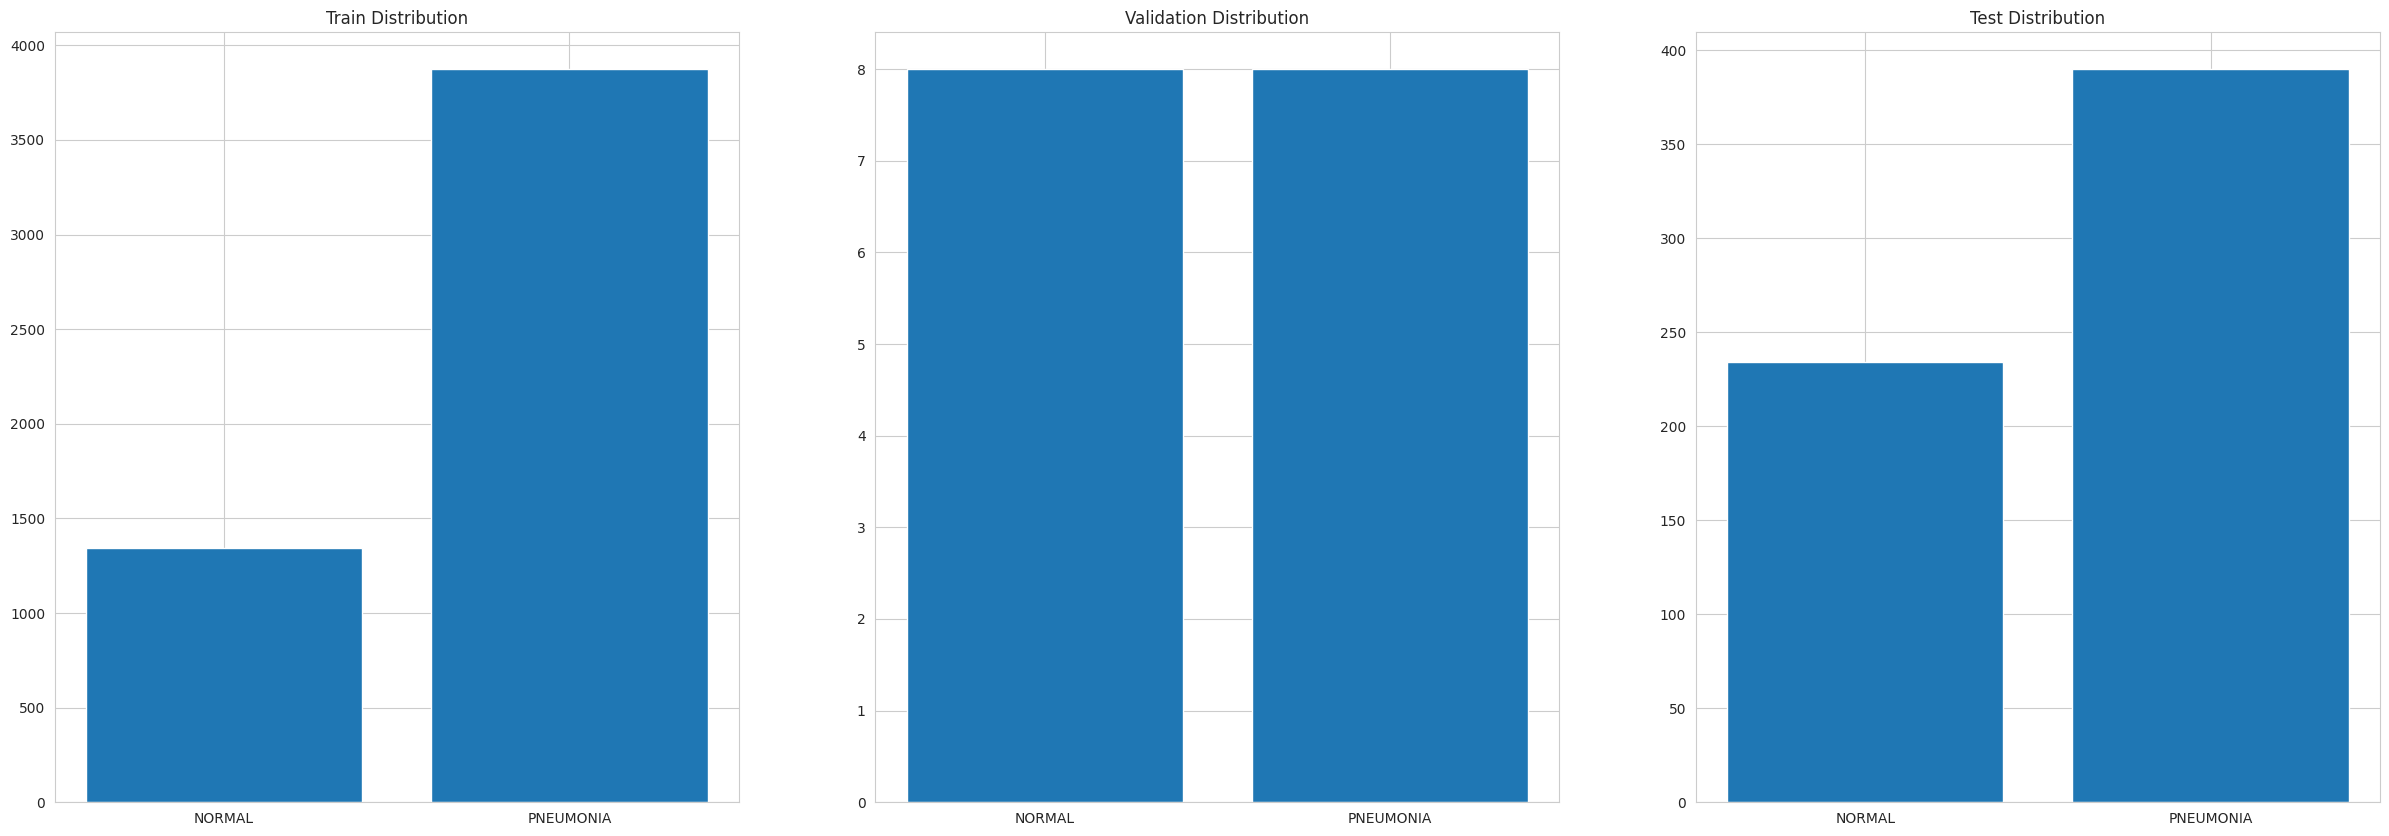

In [8]:
loader.display_distribution()